In [1]:
import pandas as pd 
import numpy as np
import os
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
frame_size = 75

In [3]:
dst_dir = "/home/thomas/RatAnalysis/RatClustering/Footshock_Session1_Fixed"

In [4]:
folders = [os.path.join(dst_dir, d) for d in os.listdir(dst_dir) if os.path.isdir(os.path.join(dst_dir, d))]
csvs = []
for folder in folders:
    
    for filename in os.listdir(folder):
        if "pose_void_tone_shock_combined" in filename:
            csvs.append(os.path.join(folder,filename))

dfs = []
for csv in csvs:
    dfs.append(pd.read_csv(csv, index_col=0))

In [5]:
pose_columns = ['RightEar_x',
    'RightEar_y',
    'LeftEar_x',
    'LeftEar_y',
    'forehead_x',
    'forehead_y',
    'shoulder_x',
    'shoulder_y',
    'Spine1_x',
    'Spine1_y',
    'Hipbone_x',
    'Hipbone_y',
    'TailBase_x',
    'TailBase_y',
    'Tail2_x',
    'Tail2_y',
    'TailEnd_x',
    'TailEnd_y',
    'R_forepaw_x',
    'R_forepaw_y',
    'L_forepaw_x',
    'L_forepaw_y',
    'R_heel_x',
    'R_heel_y',
    'R_hindpaw_x',
    'R_hindpaw_y',
    'L_heel_x',
    'L_heel_y',
    'L_hindpaw_x',
    'L_hindpaw_y']
pose_points = sorted(set([col.rsplit('_', 1)[0] for col in pose_columns]))

for index, df in enumerate(dfs):
    area_data = []  # To store area columns
    
    
    for point1, point2, point3 in combinations(pose_points, 3):
        # Extract (x, y) coordinates for the three points
        x1, y1 = df[f'{point1}_x'], df[f'{point1}_y']
        x2, y2 = df[f'{point2}_x'], df[f'{point2}_y']
        x3, y3 = df[f'{point3}_x'], df[f'{point3}_y']
        
        # Calculate the area using the shoelace formula
        area = 0.5 * np.abs(x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
        
        # Store areas in a temporary list for batch addition
        area_data.append(pd.Series(area, name=f'Area_{point1}_{point2}_{point3}'))

    # Concatenate all area columns at once to avoid fragmentation
    area_df = pd.concat(area_data, axis=1)
    df = pd.concat([df, area_df], axis=1)
    dfs[index] = df  # Update the list with the modified DataFrame
    # Iterate through all combinations of three points and add angle as a new column
    for point1, point2, point3 in combinations(pose_points, 3):
        # Extract (x, y) coordinates for the three points
        x1, y1 = df[f'{point1}_x'], df[f'{point1}_y']
        x2, y2 = df[f'{point2}_x'], df[f'{point2}_y']
        x3, y3 = df[f'{point3}_x'], df[f'{point3}_y']
        
        # Calculate the area using the shoelace formula
        area = 0.5 * np.abs(x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
        
        # Create a new column for this area
        area_col_name = f'Area_{point1}_{point2}_{point3}'
        df[area_col_name] = area

    df = df.copy() # Defragments the dataframe from inserting 1200 columns
    dfs[index] = df

In [6]:
for index, df in enumerate(dfs):
    position_columns = [col for col in df.columns if '_x' in col or '_y' in col]
    not_position_columns = [col for col in df.columns if  not '_x' in col and not '_y' in col]

    # Calculate the derivative per frame for each x and y coordinate
    df_derivative = df[position_columns].diff()
    df_derivative.columns = [f"{col}" for col in df_derivative.columns]

    df_derivative = pd.merge( df_derivative, df[not_position_columns], left_index=True, right_index=True )
    
    df_derivative = df_derivative.iloc[1:]
    df_derivative = df_derivative.reset_index()
    dfs[index] = df_derivative
    # Add a suffix to indicate these are derivatives

In [7]:
tsne_segments = []
video_ends = [0]
for i, df in enumerate(dfs):
    
    df['Group'] = df.index // frame_size

    df = df[df.index < (df['Group'].max() * frame_size)]

    df = df.reset_index(drop=True)

    df_xy = df.filter(regex='(_x|_y|^Area_)')
    
    new_values = df_xy.values.reshape(-1, len(df_xy.columns) * frame_size)

    tsne_segments.append(new_values)
    video_ends.append(video_ends[-1] + len(new_values))

    dfs[i] = df
    
tsne_input = np.vstack(tsne_segments)

video_ends.remove(0)


In [8]:
tsne = TSNE(n_components=2, random_state=42)

tsne_results = tsne.fit_transform(tsne_input)

num_clusters = 25  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(tsne_results)


# Create a DataFrame to hold the t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE_1', 'TSNE_2'])
tsne_df['Cluster'] = kmeans_labels


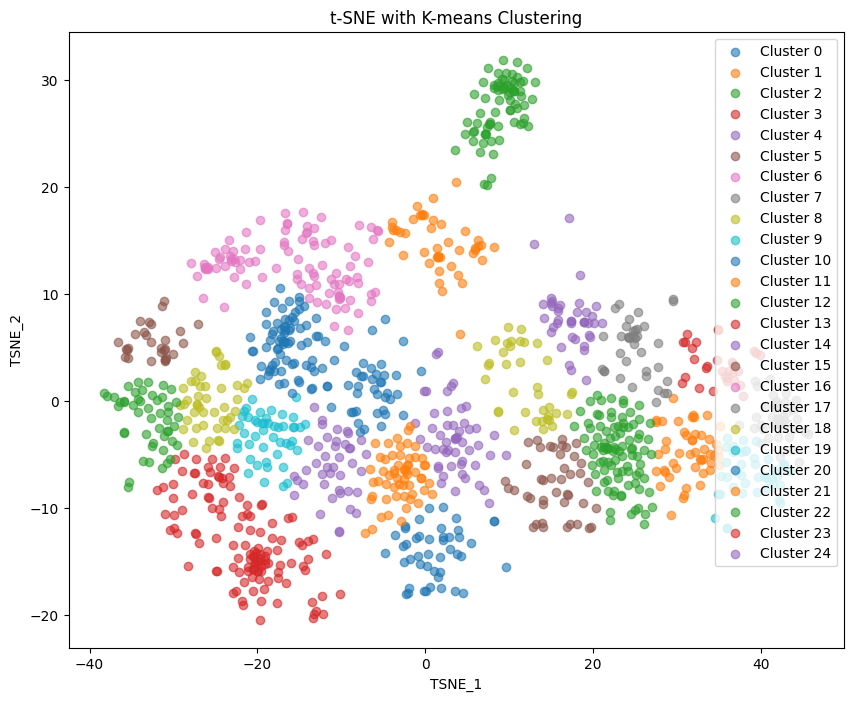

In [9]:
plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    cluster_data = tsne_df[tsne_df['Cluster'] == cluster]
    plt.scatter(cluster_data['TSNE_1'], cluster_data['TSNE_2'], label=f'Cluster {cluster}', alpha=0.6)

plt.xlabel('TSNE_1')
plt.ylabel('TSNE_2')
plt.title('t-SNE with K-means Clustering')
plt.legend()
plt.show()

In [10]:
array = []
for video, end in enumerate(video_ends):
    if video == 0:
        array.append(kmeans_labels[0:end])
    else:
        array.append(kmeans_labels[video_ends[video-1]:end] )


In [11]:
for df, kmeans in zip(dfs, array):
    df['Cluster'] = np.repeat(kmeans, frame_size)

In [12]:
grouped_dfs = []
for df in dfs:
    df1 = df.copy()
    df1 = df1.groupby('Group').agg({
        'Is_Voiding': 'max',
        'Shock_Start': 'max',
        'Shock_End': 'max',
        'Tone_Start': 'max',
        'Tone_End': 'max',
        'Seconds': 'mean',
        'Cluster': 'mean'
    }).reset_index()
    grouped_dfs.append(df1)

for i, df in enumerate(grouped_dfs):
    df['Video'] = f'Video {i+1}'
    df['Index'] = df.index
combined_df = pd.concat(grouped_dfs, ignore_index=True)

heatmap_data = combined_df.pivot_table(
    index=['Video'], 
    columns='Group', 
    values='Cluster'
)


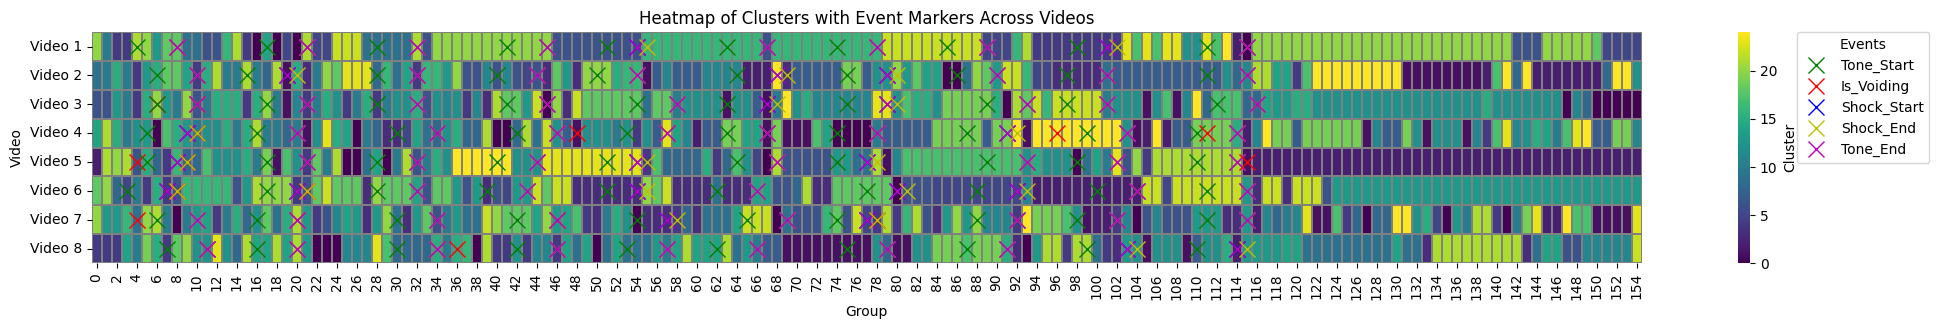

In [13]:

plt.figure(figsize=(25, 3))

ax = sns.heatmap(
    heatmap_data, 
    cmap='viridis', 
    linewidths=0.1, 
    linecolor='gray', 
    cbar_kws={'label': 'Cluster'}
)

for _, row in combined_df.iterrows():
    video_idx = combined_df['Video'].unique().tolist().index(row['Video'])  # Find the video index
    group = row['Group']  # Get the group (x-axis)
    
    # Add 'X' markers at the respective video and group positions
    if row['Is_Voiding']:
        ax.plot(group + 0.5, video_idx + 0.5, 'rx', markersize=12, label='Is_Voiding')
    if row['Shock_Start']:
        ax.plot(group + 0.5, video_idx + 0.5, 'bx', markersize=12, label='Shock_Start')
    if row['Shock_End']:
        ax.plot(group + 0.5, video_idx + 0.5, 'yx', markersize=12, label='Shock_End')
    if row['Tone_Start']:
        ax.plot(group + 0.5, video_idx + 0.5, 'gx', markersize=12, label='Tone_Start')
    if row['Tone_End']:
        ax.plot(group + 0.5, video_idx + 0.5, 'mx', markersize=12, label='Tone_End')

handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))

ax.legend(
    unique_labels.values(), 
    unique_labels.keys(), 
    bbox_to_anchor=(1.10, 1),  
    loc='upper left', 
    borderaxespad=0, 
    title='Events'
)
# Adjust labels and title
plt.xlabel('Group')
plt.ylabel('Video')
plt.title('Heatmap of Clusters with Event Markers Across Videos')
plt.show()

In [14]:
for i, df in enumerate(dfs):
    df['Video'] = f'Video {i+1}'
    dfs[i] = df
combined_df = pd.concat(dfs, ignore_index=True)

In [15]:
filtered_df = combined_df[(combined_df['Cluster'] == 19)]

In [16]:
# grouped = filtered_df.groupby(['Video', 'Group'])

# # Get the maximum number of frames (rows) in the largest group+video combination
# max_frames = max([len(group) for _, group in grouped])
# images = []

# # Iterate over each frame index
# for frame_index in range(max_frames):
#     plt.figure(figsize=(8, 6))

#     for (video, group), group_df in grouped:
#         # Ensure that the group has enough frames (rows)
#         if frame_index < len(group_df):
#             frame = group_df.iloc[frame_index]

#             # Extract (x, y) coordinates
#             right_ear_x, right_ear_y = frame['RightEar_x'], frame['RightEar_y']
#             left_ear_x, left_ear_y = frame['LeftEar_x'], frame['LeftEar_y']
#             forehead_x, forehead_y = frame['forehead_x'], frame['forehead_y']
#             nose_x, nose_y = frame['Nose_x'], frame['Nose_y']

#             # Create a scatter plot for the frame
#             plt.scatter([forehead_x], 
#                         [forehead_y],
#                         c=["Red"])

#     # Set plot title and labels
#     plt.title(f'Video: {video}, Group: {group}, Frame: {frame_index + 1}')
#     plt.xlabel('X-coordinate')
#     plt.ylabel('Y-coordinate')
#     plt.grid(True)

#     image_path = f"./temp/frame_{frame_index}.png"
#     plt.savefig(image_path)
#     images.append(image_path)


In [17]:
max_frames

NameError: name 'max_frames' is not defined